<h3 style="text-align:center">Logistic Regression with TensorFlow</h3>

<h3><u>Introduction</u></h3>

The goal of this notebook is to familiarize with the <u>TensorFlow</u>, the Deep Learning library build by Google in November 2015. <br>
Now it is the framework that it is the most used and we will use it in order to build a Logistic Regression model using the Iris dataset.

<h3><u>Package</u></h3>

First let's import the packages that we need to achieve our goal:

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

<h3>Load Iris dataset</h3>

In [3]:
# Load dataset
data = pd.read_csv('Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


To simplify things, we will only consider 2 attributes and 2 classes.

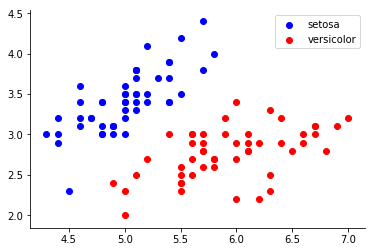

In [6]:
X = data.iloc[:100, 1:5].values
y = data.iloc[:100, 5].values

m = 100

setosa = plt.scatter(X[:50, 0], X[:50, 1], c='b', label="setosa")
versicolor = plt.scatter(X[50:, 0], X[50:, 1], c='r', label="versicolor")
plt.legend()
sns.despine()
plt.show()

We must not forget to add an extra bias feature ($x_0 = 1$) to every instance. <br>
For this, we just need to add a column full of 1s on the left of the input matrix <b>X</b>:

In [7]:
X_with_bias = np.c_[np.ones((m, 1)), X]

Let's check:

Now let's reshape y_train to make it a column vector (i.e. a 2D array with a single column):

In [15]:
y.shape

(100,)

In [16]:
y_column_vector = y.reshape(-1, 1)
y_column_vector.shape

(100, 1)

Finally, we convert the Species into number, in this case, we will impose <br>
'Iris-setosa' = 1 and 'Iris-versicolor' = 0

In [17]:
y_bin = (np.where(y_column_vector == 'Iris-setosa', 1, 0))

In [28]:
X_with_bias.shape

(100, 5)

In [27]:
y_bin.shape

(100, 1)

In [36]:
full_data = np.concatenate((X_with_bias, y_bin), axis=1)

In [50]:
full_data.shape

(100, 6)

<h3><u>Train/Test set split</u></h3>

We will split the loaded dataset into two, <b>80%</b> of which we will use to train our model and <b>20%</b> that we will hold back as a test dataset.

In [18]:
np.random.seed(42) # To make output consistent in this notebook

In [45]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data[train_indices], data[test_indices]

In [51]:
test_ratio = 0.2
train, test = split_train_test(full_data, test_ratio=test_ratio)
print("Train size:", train.shape, "Test size:", test.shape)

Train size: (80, 6) Test size: (20, 6)


In [58]:
X_train, y_train = train[:, 0:5], train[:, -1].reshape(-1, 1)
X_test, y_test = test[:, 0:5], test[:, -1].reshape(-1, 1)
print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape, "y_test.shape:", y_test.shape)

X_train.shape: (80, 5) y_train.shape: (80, 1)
X_test.shape: (20, 5) y_test.shape: (20, 1)


<h3><u>TensorFlow</u></h3>

Let's the reset the default graph:

In [62]:
tf.reset_default_graph()

Now let's define the <b>logistic_regression()</b> function to create the graph. We will leave out the definition of the inputs X and the targets y. We could include them here, but leaving them out will make it easier to use this function in a wide range of use cases (e.g. perhaps we will want to add some preprocessing steps for the inputs before we feed them to the Logistic Regression model).

In [ ]:
s